# connectivity

The measurement of functional connectivity is a very commonly used and effective function. Below, I will provide a detailed explanation of the call parameters of functional connectivity functions, as shown in source code [1](https://scut-eeg-feature.readthedocs.io/en/latest/_modules/scuteegfe/features/any_feature.html#compute_correlation_matrix), and give appropriate examples.

## Import related packages

In [11]:
import warnings
warnings.filterwarnings('ignore')
from scuteegfe import Feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from nilearn import plotting
import matplotlib.cm as cm
from mne_connectivity.viz import plot_connectivity_circle

## get motor image data

In [12]:
def get_data_example_motor_image():
    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    subject = 1
    runs = [6, 10, 14]  # motor imagery: hands vs feet
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2
    data = epochs.get_data()
    print(data.shape)
    return data, labels

In [13]:
data, _ = get_data_example_motor_image()
# 7-channel data are used.
data = data[:,:7,:]


Extracting EDF parameters from C:\Users\15956\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\15956\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\15956\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hammi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
(45, 64, 801)


In [14]:
n_epcoh, n_channels, n_samples = data.shape
print(f"data.shape: {n_epcoh} epcoh X {n_channels} channels X {n_samples} samples")

data.shape: 45 epcoh X 7 channels X 801 samples


## Connectivity Function

The function used to measure functional connection calls is `correlation_matrix`. 

### Available Options for the Parameter `kind`:
- **covariance**: Measures the covariance between signals.
- **correlation**: Measures the Pearson correlation coefficient between signals.
- **partial correlation**: Measures the partial correlation, accounting for the influence of other signals.
- **tangent**: Computes the tangent connectivity measure. For usage, see Varoquaux et al [^1].
- **precision**: Measures the precision of the connectivity.
- **coh**: Coherence.
- **cohy**: Coherency.
- **imcoh**: Imaginary part of Coherency.
- **cacoh**: Canonical Coherency (CaCoh).
- **mic**: Maximised Imaginary part of Coherency (MIC).
- **mim**: Multivariate Interaction Measure (MIM).
- **plv**: Phase-Locking Value (PLV).
- **ciplv**: Corrected Imaginary PLV (ciPLV).
- **ppc**: Pairwise Phase Consistency (PPC).
- **pli**: Phase Lag Index (PLI).
- **pli2_unbiased**: Unbiased estimator of squared PLI.
- **dpli**: Directed PLI (DPLI).
- **wpli**: Weighted PLI (WPLI).
- **wpli2_debiased**: Debiased estimator of squared WPLI.
- **gc**: State-space Granger Causality (GC).
- **gc_tr**: State-space GC on time-reversed signals.
- **pec**: power envolope correlation on time-reversed signals.

### Reference
[^1]: Gael Varoquaux, Flore Baronnet, Andreas Kleinschmidt, Pierre Fillard, and Bertrand Thirion. Detection of brain functional-connectivity difference in post-stroke patients using group-level covariance modeling. In Tianzi Jiang, Nassir Navab, Josien P. W. Pluim, and Max A. Viergever, editors, *Medical Image Computing and Computer-Assisted Intervention - MICCAI 2010*, Lecture Notes in Computer Science, 200–208. Berlin, Heidelberg, 2010. Springer. [doi:10/cn2h9c](https://link.springer.com/chapter/10.1007/978-3-642-15705-9_25).

### pec: power envolope  correlation

In [15]:
fea = Feature(data, sfreq=160, selected_funcs=['correlation_matrix'], 
              funcs_params={"correlation_matrix__sfreq":160,"correlation_matrix__kind":"pec"})

(45, 7, 7)
feature shape: 45 epcoh X 7 channels X 7 channels


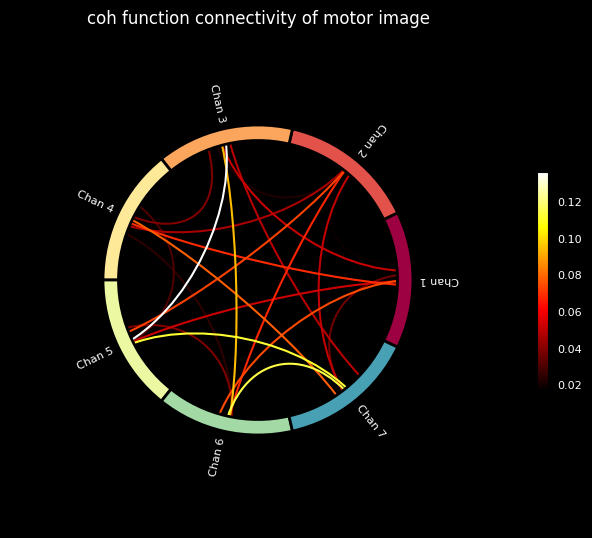

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'coh function connectivity of motor image'}>)

In [16]:
print(fea.features.shape)
n_epoch,n_channel,n_channel = fea.features.shape
print(f"feature shape: {n_epcoh} epcoh X {n_channels} channels X {n_channels} channels")
fig, ax = plt.subplots(figsize=(8, 8),  facecolor="Black", subplot_kw=dict(polar=True))
plot_connectivity_circle(fea.features[0], [f'Chan {i+1}' for i in range(n_channels)],
                         title=f'coh function connectivity of motor image',
                    colormap="hot",  colorbar_size=0.35, colorbar_pos=(0, 0.5), ax=ax)

### coh: Coherence.            

In [17]:
fea = Feature(data, sfreq=160, selected_funcs=['correlation_matrix'], 
              funcs_params={"correlation_matrix__sfreq":160,"correlation_matrix__kind":"coh"})

(45, 7, 7)
feature shape: 45 epcoh X 7 channels X 7 channels


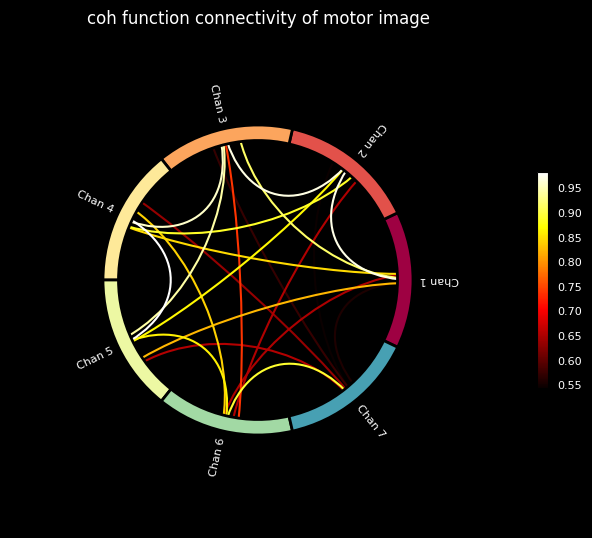

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'coh function connectivity of motor image'}>)

In [18]:
print(fea.features.shape)
n_epoch,n_channel,n_channel = fea.features.shape
print(f"feature shape: {n_epcoh} epcoh X {n_channels} channels X {n_channels} channels")
fig, ax = plt.subplots(figsize=(8, 8),  facecolor="Black", subplot_kw=dict(polar=True))
plot_connectivity_circle(fea.features[0], [f'Chan {i+1}' for i in range(n_channels)],
                         title=f'coh function connectivity of motor image',
                    colormap="hot",  colorbar_size=0.35, colorbar_pos=(0, 0.5), ax=ax)

### covariance: Covariance.    
meature covariance for alpha frequency band.   

In [ ]:
fea2 = Feature(data, sfreq=160, selected_funcs=['correlation_matrix'], 
               funcs_params={"correlation_matrix__sfreq":160,"correlation_matrix__kind":"covariance",
                             "correlation_matrix__filter_bank":[8,12]})

(45, 7, 7)
feature shape: 45 epcoh X 7 channels X 7 channels


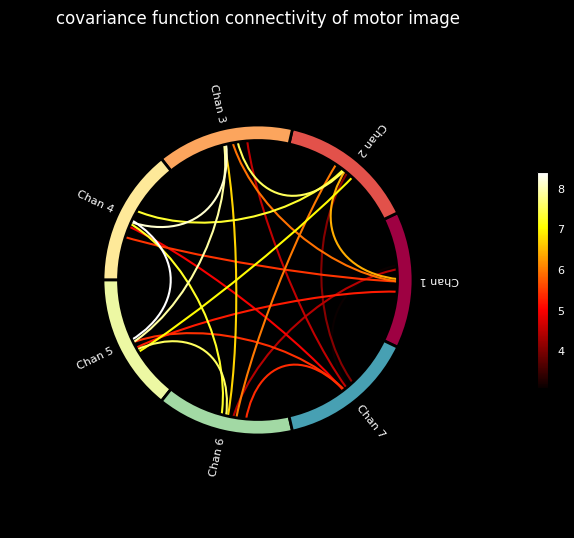

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'covariance function connectivity of motor image'}>)

In [22]:
print(fea2.features.shape)
n_epoch,n_channel,n_channel = fea2.features.shape
print(f"feature shape: {n_epcoh} epcoh X {n_channels} channels X {n_channels} channels")
fig, ax = plt.subplots(figsize=(8, 8),  facecolor="Black", subplot_kw=dict(polar=True))
plot_connectivity_circle(fea2.features[0], [f'Chan {i+1}' for i in range(n_channels)],
                         title=f'covariance function connectivity of motor image',
                    colormap="hot",  colorbar_size=0.35, colorbar_pos=(0, 0.5), ax=ax)